# Data Loading and Cleaning

Loads and examines the initial structure of the datasets required.

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore, pearsonr
import re
from datetime import datetime

In [2]:
# Load Data
# df_adjusted = pd.read_csv('../data/combined_data_season_adjusted.csv')
# df_not_adjusted = pd.read_csv('../data/combined_data_season_not_adjusted.csv')
# categories = pd.read_csv('../data/code_categories.csv')

In [3]:
# Load Data
df_adjusted = pd.read_csv('../data/MRTS_adjusted.csv')
df_not_adjusted = pd.read_csv('../data/MRTS_not_adjusted.csv')
categories = pd.read_csv('../data/mrts_code_categories.csv')

- **`df_adjusted` (*combined_data_season_adjusted*)**: Contains the main dataset with seasonally adjusted sales data for retail and food services from 2017–2023.
- 
**`df_not_adjusted` (*combined_data_season_not_adjusted*)**: Contains the main dataset with raw sales data for retail and food services from 2017–2023.
  
- **`categories` (*code_categories*)**: Provides a mapping of category codes to descriptive names, enabling a better understanding of each retail and food service segment.


In [4]:
df_adjusted.head()

,cell_value,time_slot_id,data_type_code,category_code,error_data,seasonally_adj,data_type_code.1,time,us
0,91596,0,SM,441X,no,yes,SM,2017-01,1
1,91088,0,SM,441X,no,yes,SM,2017-02,1
2,89067,0,SM,441X,no,yes,SM,2017-03,1
3,89571,0,SM,441X,no,yes,SM,2017-04,1
4,90043,0,SM,441X,no,yes,SM,2017-05,1


In [5]:
df_not_adjusted.head()

,cell_value,time_slot_id,data_type_code,category_code,error_data,seasonally_adj,data_type_code.1,time,us
0,74647,0,SM,4411,no,no,SM,2017-01,1
1,77728,0,SM,4411,no,no,SM,2017-02,1
2,91143,0,SM,4411,no,no,SM,2017-03,1
3,82286,0,SM,4411,no,no,SM,2017-04,1
4,89634,0,SM,4411,no,no,SM,2017-05,1


In [6]:
categories.head()

,category_code,category_name,high_level_category,is_subset
0,44X72,Retail Trade and Food Services,Retail Trade and Food Services,False
1,44Y72,"Retail Trade and Food Services, ex Auto",Retail Trade and Food Services,True
2,44Z72,"Retail Trade and Food Services, ex Gas",Retail Trade and Food Services,True
3,44W72,"Retail Trade and Food Services, ex Auto and Gas",Retail Trade and Food Services,True
4,44000,Retail Trade,Retail Trade and Food Services,True


In [7]:
df_adjusted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   cell_value        3192 non-null   object
 1   time_slot_id      3192 non-null   int64 
 2   data_type_code    3192 non-null   object
 3   category_code     3192 non-null   object
 4   error_data        3192 non-null   object
 5   seasonally_adj    3192 non-null   object
 6   data_type_code.1  3192 non-null   object
 7   time              3192 non-null   object
 8   us                3192 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 224.6+ KB


In [8]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category_code        65 non-null     object
 1   category_name        65 non-null     object
 2   high_level_category  65 non-null     object
 3   is_subset            65 non-null     bool  
dtypes: bool(1), object(3)
memory usage: 1.7+ KB


In [9]:
df_adjusted.columns

Index(['cell_value', 'time_slot_id', 'data_type_code', 'category_code',
       'error_data', 'seasonally_adj', 'data_type_code.1', 'time', 'us'],
      dtype='object')

In [10]:
pd.options.display.float_format = '{:.2f}'.format

As the dataset contains no `null` values, we proceed to examine the unique values in each column to understand the variability and structure of the data.

In [11]:
for column in df_adjusted.columns:
    print(f"Column: {column}")
    print(f"Unique values: {df_adjusted[column].unique()}")
    print(f"Number of unique values: {df_adjusted[column].nunique()}\n")

for column in categories.columns:
    print(f"Column: {column}")
    print(f"Unique values: {categories[column].unique()}")
    print(f"Number of unique values: {categories[column].nunique()}\n")

Column: cell_value
Unique values: ['91596' '91088' '89067' ... '28784' '2528' '2737']
Number of unique values: 3044

Column: time_slot_id
Unique values: [0]
Number of unique values: 1

Column: data_type_code
Unique values: ['SM']
Number of unique values: 1

Column: category_code
Unique values: ['441X' '4400A' '4413' '4400C' '44000' '441' '4423X' '444' '4441' '4451'
 '442' '446' '443' '445' '4453' '4481' '44812' '44811' '44611' '448' '447'
 '722' '451' '44W72' '45291' '452' '44Y72' '45299' '44X72' '454' '453'
 '4541' '4482' '44831' '4521E' '45431' '44Z72' '4529']
Number of unique values: 38

Column: error_data
Unique values: ['no']
Number of unique values: 1

Column: seasonally_adj
Unique values: ['yes']
Number of unique values: 1

Column: data_type_code.1
Unique values: ['SM']
Number of unique values: 1

Column: time
Unique values: ['2017-01' '2017-02' '2017-03' '2017-04' '2017-05' '2017-06' '2017-07'
 '2017-08' '2017-09' '2017-10' '2017-11' '2017-12' '2018-01' '2018-02'
 '2018-03' '20

Convert data types to appropriate types

 - `time` to `Datetime` format for easier analysis.

In [12]:
df_adjusted['time'] = pd.to_datetime(df_adjusted['time'], format='%Y-%m')
df_not_adjusted['time'] = pd.to_datetime(df_not_adjusted['time'], format='%Y-%m')
df_adjusted = df_adjusted.sort_values(by='time', ascending=True)
df_not_adjusted = df_not_adjusted.sort_values(by='time', ascending=True)

- `cell_value`'s type `string` to `integer` so it represents monthly sales

In [13]:
df_adjusted["monthly_sales"] = pd.to_numeric(df_adjusted["cell_value"], errors='coerce') # Convert to numeric, invalid values become NaN
df_not_adjusted["monthly_sales"] = pd.to_numeric(df_not_adjusted["cell_value"], errors='coerce') 
non_convertible_values = df_adjusted[df_adjusted["monthly_sales"].isna()]["cell_value"].unique() + df_adjusted[df_adjusted["monthly_sales"].isna()]["cell_value"].unique()

print("Adjusted Non-convertible values:", non_convertible_values, "Not Adjusted Non-convertible values:", non_convertible_values)

Adjusted Non-convertible values: ['(S)(S)'] Not Adjusted Non-convertible values: ['(S)(S)']


Since `(S)` values are suppressed, we will keep this as `null`

In [14]:
num_null_adjusted = df_adjusted["monthly_sales"].isna().sum()
num_null_not_adjusted = df_not_adjusted["monthly_sales"].isna().sum()

print(f"Adjusted Data Null Values: {num_null_adjusted}")
print(f"Not Adjusted Data Null Values: {num_null_not_adjusted}")

# Distribution of rows with (S) values by category
s_values_distribution_adjusted = df_adjusted[df_adjusted["monthly_sales"].isna()]["category_code"].value_counts()
s_values_distribution_not_adjusted = df_not_adjusted[df_not_adjusted["monthly_sales"].isna()]["category_code"].value_counts()

print("Adjusted Data Distribution of (S) Values by Category:")
print(s_values_distribution_adjusted)

print("Not Adjusted Data Distribution of (S) Values by Category:")
print(s_values_distribution_not_adjusted)

Adjusted Data Null Values: 68
Not Adjusted Data Null Values: 345
Adjusted Data Distribution of (S) Values by Category:
category_code
44811    34
44831    34
Name: count, dtype: int64
Not Adjusted Data Distribution of (S) Values by Category:
category_code
44221     82
7224      70
722511    47
4422      39
442299    39
44811     34
44831     34
Name: count, dtype: int64


In [15]:
categories[categories['category_code'].isin(["44221", "7224", "722511", "4422", "442299", "44811", "44831"])]

,category_code,category_name,high_level_category,is_subset
16,4422,Home Furnishings Stores,Furniture and Home Furnishings Stores,True
17,44221,Floor Covering Stores,Furniture and Home Furnishings Stores,True
18,442299,All Other Home Furnishings Stores,Furniture and Home Furnishings Stores,True
35,44811,Men's Clothing Stores,Clothing and Clothing Accessories Stores,True
40,44831,Jewelry Stores,Clothing and Clothing Accessories Stores,True
61,7224,Drinking Places,Food Services and Drinking Places,True
63,722511,Full Service Restaurants,Food Services and Drinking Places,True


As categories `Floor Covering Stores`, `Drinking Places`, and `Full Service Restaurants` have more than half of the availabe data as null, and there are more relevant categories remaining such as `Furniture, Home Furnishings, Electronics, and Appliance Stores` and `Food Services and Drinking Places`, we will be removing the categories. 

In [16]:
df_not_adjusted = df_not_adjusted[~df_not_adjusted['category_code'].isin(["44221", "7224", "722511"])]
df_adjusted = df_adjusted[~df_adjusted['category_code'].isin(["44221", "7224", "722511"])]

Rename column names for better interpretation.

In [17]:
df_adjusted = df_adjusted.rename(columns={'seasonally_adj': 'seasonally_adjusted'})
df_not_adjusted = df_not_adjusted.rename(columns={'seasonally_adj': 'seasonally_adjusted'})
df_adjusted['seasonally_adjusted'] = df_adjusted['seasonally_adjusted'].map({'yes': True, 'no': False})
df_not_adjusted['seasonally_adjusted'] = df_not_adjusted['seasonally_adjusted'].map({'yes': True, 'no': False})

Proceed to drop unnecessary columns.

In [18]:
df_adjusted = df_adjusted.drop(columns=['time_slot_id', 'us','data_type_code', 'data_type_code.1', 'cell_value', 'error_data', 'seasonally_adjusted'])
df_not_adjusted = df_not_adjusted.drop(columns=['time_slot_id', 'us','data_type_code', 'data_type_code.1', 'cell_value', 'error_data','seasonally_adjusted'])

Merge the main dataset with a mapping dataset (categories) using the `category_code` column. 

This step assigns descriptive names to each `category_code`, making the dataset more interpretable.

In [19]:
df_adjusted = df_adjusted.merge(categories, on='category_code', how='left')
df_not_adjusted = df_not_adjusted.merge(categories, on='category_code', how='left')

Reorder columns for convenience.

In [20]:
column_order = ['monthly_sales','category_code','time','category_name','high_level_category','is_subset']
df_adjusted = df_adjusted[column_order]
df_not_adjusted = df_not_adjusted[column_order]

To analyze market risks effectively, the **Coefficient of Variation (CV)** will be added to the dataset. This will be added to the seasonally adjusted data to exclude seasonal patterns and focus soley on intrinsic volatility. 

**Normalized standard deviation** highlights absolute variability in a scaled manner, offering complementary insights alongside the CV.

In [21]:
category_stats = (
    df_adjusted.groupby(["category_name", "is_subset"])["monthly_sales"]
    .agg(
        mean_sales="mean",
        std_sales="std"
    )
    .reset_index()
)
# coefficient of variation
category_stats["cv"] = category_stats["std_sales"] / category_stats["mean_sales"]

df_adjusted = pd.merge(
    df_adjusted, 
    category_stats[["category_name", "cv"]], 
    on="category_name",
    how="left"
)

df_adjusted.head()

,monthly_sales,category_code,time,category_name,high_level_category,is_subset,cv
0,91596.00,441X,2017-01-01,Auto and Other Motor Vehicles,Motor Vehicle and Parts Dealers,True,0.13
1,59565.00,445,2017-01-01,Food and Beverage Stores,Food and Beverage Stores,False,0.11
2,473019.00,44X72,2017-01-01,Retail Trade and Food Services,Retail Trade and Food Services,False,0.15
3,57644.00,452,2017-01-01,General Merchandise Stores,General Merchandise Stores,False,0.10
4,7216.00,451,2017-01-01,"Sporting Goods, Hobby, Musical Instrument, and...","Sporting Goods, Hobby, Musical Instrument, and...",False,0.13


In [22]:
output_directory = "../data/"

# Export DataFrames to CSV files
# df_adjusted.to_csv(f"{output_directory}df_adjusted.csv", index=False, na_rep="NULL")
# df_not_adjusted.to_csv(f"{output_directory}df_not_adjusted.csv", index=False, na_rep="NULL")

## CPI Data Cleaning

Besides the main data, below, we are processing and combining **Consumer Price Index (CPI)** data from Bureau of Labor Statistics. Individual Excel files spanning **January 2017 to October 2024** has been downloaded. Yet due to the original formatting, there are numerous null values, extra rows, and unnecessary columns. The next steps will clean, process, and combine each files with **Indent Level**, **Expenditure Category**, and **Monthly CPI Values**.


In [23]:
df = pd.read_excel("../data/cpi/cpi-u-201910.xlsx", header=None)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,Consumer Price Index for All Urban Consumers (...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[1982-84=100, unless otherwise noted]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Expenditure category,Relative\nimportance\nSep.\n2019,Unadjusted indexes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,One Month,NaN,NaN,NaN,Twelve Month,NaN,NaN,NaN
4,NaN,NaN,Oct.\n2018,Nov.\n2018,Dec.\n2018,Jan.\n2019,Feb.\n2019,Mar.\n2019,Apr.\n2019,May\n2019,...,Aug.\n2019-\nSep.\n2019,Sep.\n2019-\nOct.\n2019,Seasonally adjusted effect on All Items\nSep. ...,"Standard error, median price change(2)",Largest (L) or Smallest (S) seasonally adjuste...,NaN,Unadjusted effect on All Items\nOct. 2018-\nOc...,"Standard error, median price change(2)(4)",Largest (L) or Smallest (S) unadjusted change ...,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Date,Percent change,NaN,NaN,Date,Percent change
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,All items,100,252.88,252.04,251.23,251.71,252.78,254.20,255.55,256.09,...,0,0.40,NaN,0.04,L-Mar. 2019,0.40,NaN,–,L-Jul. 2019,1.80
8,Food,13.24,254.36,254.38,255.21,256.42,257.22,257.72,257.71,258.11,...,0.10,0.20,0.03,0.08,L-May 2019,0.30,0.27,–,L-Mar. 2019,2.10
9,Food at home,7.18,239.88,239.35,239.99,241.38,242.06,242.56,241.88,242.15,...,0,0.30,0.02,0.12,L-May 2019,0.30,0.07,–,L-May 2019,1.20


In [24]:
row_values = df.iloc[3]
row_values.unique()

array(['Expenditure category', 'Relative\nimportance\nSep.\n2019',
       'Unadjusted indexes', nan, 'Seasonally adjusted indexes',
       'Unadjusted percent change', 'Seasonally adjusted percent change',
       'One Month', 'Twelve Month'], dtype=object)

In [25]:
def process_and_combine_cpi_data(folder_path, start_date="201701", end_date="202410"):
    """
    Processes and combines monthly CPI data from individual Excel files into a unified DataFrame.

    Parameters:
        folder_path (str): Path to the folder containing CPI Excel files.
        start_date (str): Start date in YYYYMM format (default: "201701").
        end_date (str): End date in YYYYMM format (default: "202410").

    Returns:
        pd.DataFrame: A DataFrame containing the cleaned and combined CPI data.
    """
    
    first_file_processed = False

    month_map = {
        "01": "Jan", "02": "Feb", "03": "Mar", "04": "Apr",
        "05": "May", "06": "Jun", "07": "Jul", "08": "Aug",
        "09": "Sep", "10": "Oct", "11": "Nov", "12": "Dec",
    }

    combined_data = None
    
    # Loop through files based on year and month
    for year in range(int(start_date[:4]), int(end_date[:4]) + 1):
        for month in range(1, 13):
            year_month = f"{year}{str(month).zfill(2)}"
            if year_month < start_date or year_month > end_date:
                continue

            file_name = f"cpi-u-{year_month}.xlsx"
            file_path = os.path.join(folder_path, file_name)

            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue

            try:
                # print(f"Reading file for {year_month}...")
                df = pd.read_excel(file_path, header=None)

                month_str = month_map[str(month).zfill(2)]
                target_column_name = (
                    f"{month_str}\n{year}" if month == 5 else f"{month_str}.\n{year}"
                )

                # Extract column names from the 4th indexed row, as this contains the monthly dates as columns.
                # Expenditure category is on the 3rd indexed row
                date_column_names = df.iloc[4]
                target_column_index = date_column_names[date_column_names == target_column_name].index
                category_column_names = df.iloc[3]
                category_column_index = category_column_names[category_column_names == "Expenditure category"].index

                # Ensure Expenditure category names are unified and has no footnote numbers
                df.iloc[:, category_column_index[0]] = (
                     df.iloc[:, category_column_index[0]]
                    .astype(str)  # Ensure the column is of string type
                    .str.replace(r'[^a-zA-Z\s,]', '', regex=True)  # Remove unwanted characters
                    .str.strip()  # Remove leading and trailing spaces
                )
       
                if target_column_index.empty:
                    print(f"Target column '{target_column_name}' not found.")
                    continue

                if not first_file_processed:
                    columns_to_keep = [0, 1, target_column_index[0]]
                else:
                    columns_to_keep = [category_column_index[0], target_column_index[0]]

                df_selected = df.iloc[7:, columns_to_keep]
                new_column_name = datetime.strptime(year_month, "%Y%m").strftime("%Y-%m") # Better column name for month dates.

                # Select Indent Level, Expenditure category, and the actual cpi value for the month for the data columns.
                if not first_file_processed:
                    df_selected.columns = ['Indent Level', 'Expenditure category', new_column_name]
                    df_selected = df_selected[df_selected['Expenditure category'] != "Special aggregate indexes"].reset_index(drop=True) # Remove row that doens't have information but is just categorizing
                    df_selected = df_selected[df_selected['Indent Level'] <= 2].reset_index(drop=True) # Remove rows that are too specific in categories.
                    first_file_processed = True
                else:
                    df_selected.columns = ['Expenditure category', new_column_name]

                df_selected = df_selected.dropna(subset=['Expenditure category']).reset_index(drop=True)

                # Drop rows after 'Personal care' as expenditure category -- these are just footnotes from the excel sheet.
                end_index = df_selected[df_selected['Expenditure category'] == "Personal care"].index
                if not end_index.empty:
                    df_selected = df_selected.loc[:end_index[0]]
                if combined_data is None:
                    combined_data = df_selected
                else:
                    combined_data = pd.merge(
                        combined_data,
                        df_selected,
                        on=['Expenditure category'],
                        how='left',
                    )
                    
            except Exception as e:
                print(f"Error processing file '{file_name}': {e}")

    return combined_data


In [26]:
cpi_df = process_and_combine_cpi_data("../data/cpi")

In [27]:
cpi_df

,Indent Level,Expenditure category,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,...,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10
0,0,All items,242.84,243.60,243.80,244.52,244.73,244.96,244.79,245.52,...,308.42,310.33,312.33,313.55,314.07,314.18,314.54,314.80,315.30,315.66
1,1,Food,248.24,248.79,249.16,249.74,250.02,249.65,250.21,250.49,...,327.33,327.73,328.04,328.68,329.12,329.71,330.56,330.75,332.08,332.68
2,2,Food at home,237.37,237.92,238.26,238.82,238.96,238.30,238.95,238.84,...,305.04,305.47,305.43,305.71,305.68,305.75,306.64,306.40,307.77,308.20
3,2,Food away from home,266.08,266.63,267.06,267.65,268.13,268.23,268.65,269.52,...,363.25,363.60,364.55,365.81,367.10,368.62,369.38,370.35,371.60,372.49
4,1,Energy,199.61,198.19,198.60,202.87,203.13,204.65,202.55,205.89,...,270.42,276.33,285.00,290.76,290.14,286.68,287.87,282.61,275.74,272.81
5,2,Energy commodities,211.11,206.98,209.03,216.79,213.61,209.91,205.22,212.98,...,284.63,296.37,313.86,328.80,326.79,314.30,316.80,308.30,293.27,288.36
6,2,Energy services,197.77,198.82,197.71,198.91,202.40,208.85,209.08,208.45,...,267.48,267.66,267.66,264.25,265.03,270.67,270.57,268.42,269.59,268.56
7,1,All items less food and energy,250.08,251.14,251.29,251.64,251.84,252.01,251.94,252.46,...,313.62,315.42,317.09,317.98,318.63,319.00,319.21,320.02,321.11,321.76
8,2,Commodities less food and energy commodities,144.37,145.14,145.53,145.66,145.12,144.58,143.91,143.90,...,164.87,165.75,165.88,165.70,165.56,165.49,164.84,164.91,165.53,165.09
9,2,Services less energy services,315.28,316.51,316.48,316.97,317.67,318.35,318.67,319.56,...,408.05,410.43,413.18,414.83,416.05,416.73,417.59,418.90,420.29,421.73


In [28]:
cpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 96 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Indent Level          51 non-null     object
 1   Expenditure category  51 non-null     object
 2   2017-01               51 non-null     object
 3   2017-02               51 non-null     object
 4   2017-03               51 non-null     object
 5   2017-04               51 non-null     object
 6   2017-05               51 non-null     object
 7   2017-06               51 non-null     object
 8   2017-07               51 non-null     object
 9   2017-08               51 non-null     object
 10  2017-09               51 non-null     object
 11  2017-10               51 non-null     object
 12  2017-11               51 non-null     object
 13  2017-12               51 non-null     object
 14  2018-01               51 non-null     object
 15  2018-02               51 non-null     obje

In [29]:
# Export CPI Dataframe to CSV
# cpi_df.to_csv(f"{output_directory}cpi_cleaned.csv", index=False, na_rep="NULL")

# Visualizations

In [30]:
sales_trends = df_adjusted.copy()
sales_trends['year'] = df_adjusted['time'].dt.year
yearly_sales_avg = sales_trends.groupby(['year', 'category_name', 'high_level_category'])['monthly_sales'].mean().reset_index()
yearly_sales_sum = sales_trends.groupby(['year', 'category_name', 'high_level_category', 'is_subset'])['monthly_sales'].sum().reset_index()
yearly_sales_sum['yoy_percentage'] = yearly_sales_sum.groupby('category_name')['monthly_sales'].pct_change() * 100
sales_avg = sales_trends.groupby(['category_name', 'is_subset','time'])['monthly_sales'].mean().reset_index()
sales_sum = sales_trends.groupby(['category_name'])['monthly_sales'].sum().reset_index()

In [31]:
sales_avg.sort_values(by=['monthly_sales'], ascending=False)

,category_name,is_subset,time,monthly_sales
2519,Retail Trade and Food Services,False,2023-12-01,703256.00
2516,Retail Trade and Food Services,False,2023-09-01,702109.00
2518,Retail Trade and Food Services,False,2023-11-01,700707.00
2517,Retail Trade and Food Services,False,2023-10-01,698956.00
2515,Retail Trade and Food Services,False,2023-08-01,696238.00
...,...,...,...,...
1927,Men's Clothing Stores,True,2023-08-01,NaN
1928,Men's Clothing Stores,True,2023-09-01,NaN
1929,Men's Clothing Stores,True,2023-10-01,NaN
1930,Men's Clothing Stores,True,2023-11-01,NaN


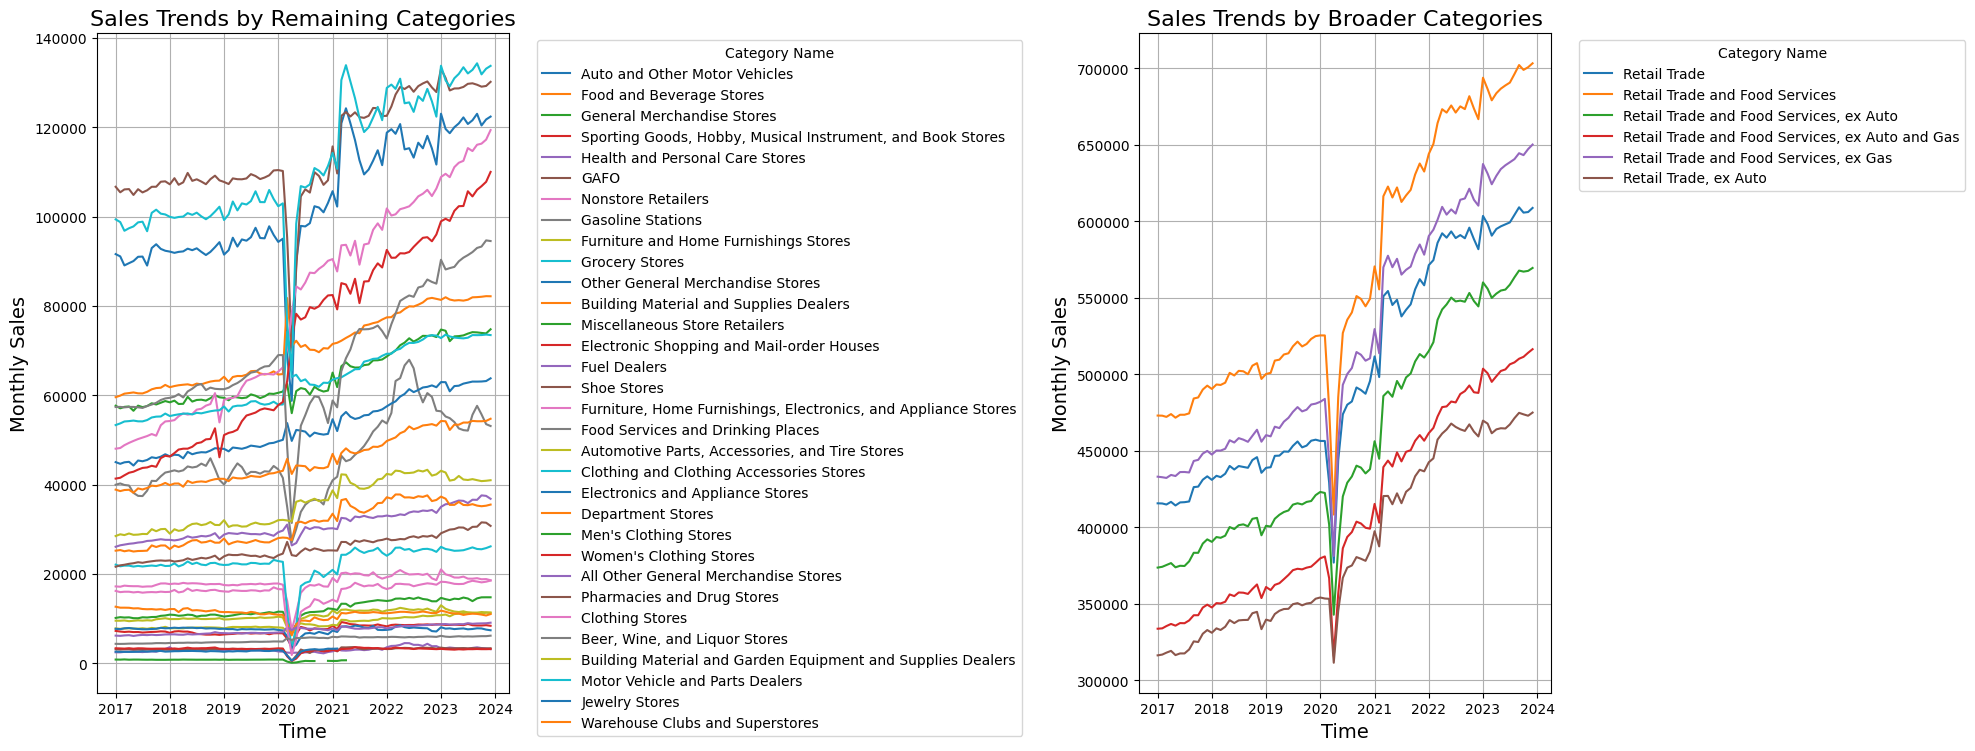

In [32]:
top_categories = ['Retail Trade and Food Services', 'Retail Trade and Food Services, ex Gas', 'Retail Trade', 
                  'Retail Trade and Food Services, ex Auto', 'Retail Trade and Food Services, ex Auto and Gas', 
                  'Retail Trade, ex Auto']
sales_trends_top = sales_avg[sales_avg['category_name'].isin(top_categories)]
remaining_categories = sales_avg[~sales_avg['category_name'].isin(top_categories)]['category_name']
sales_trends_remaining = sales_trends[sales_trends['category_name'].isin(remaining_categories)]
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
for category in sales_trends_remaining['category_name'].unique():
    category_data = sales_trends_remaining[sales_trends_remaining['category_name'] == category]
    plt.plot(category_data['time'], category_data['monthly_sales'], label=category)

plt.title('Sales Trends by Remaining Categories', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Monthly Sales', fontsize=14)
plt.legend(title='Category Name', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(visible=True)

# Top 6 categories
plt.subplot(1, 2, 2)
for category in sales_trends_top['category_name'].unique():
    category_data = sales_trends_top[sales_trends_top['category_name'] == category]
    plt.plot(category_data['time'], category_data['monthly_sales'], label=category)

plt.title('Sales Trends by Broader Categories', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Monthly Sales', fontsize=14)
plt.legend(title='Category Name', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(visible=True)

plt.tight_layout()
plt.show()


In [33]:
yearly_sales_sum

,year,category_name,high_level_category,is_subset,monthly_sales,yoy_percentage
0,2017,All Other General Merchandise Stores,Other General Merchandise Stores,True,75064.00,NaN
1,2017,Auto and Other Motor Vehicles,Motor Vehicle and Parts Dealers,True,1094315.00,NaN
2,2017,"Automotive Parts, Accessories, and Tire Stores",Motor Vehicle and Parts Dealers,True,93643.00,NaN
3,2017,"Beer, Wine, and Liquor Stores",Food and Beverage Stores,True,52671.00,NaN
4,2017,Building Material and Garden Equipment and Sup...,Building Material and Garden Equipment and Sup...,False,349987.00,NaN
...,...,...,...,...,...,...
261,2023,"Retail Trade, ex Auto",Retail Trade and Food Services,True,5627256.00,1.95
262,2023,Shoe Stores,Clothing and Clothing Accessories Stores,True,40077.00,0.36
263,2023,"Sporting Goods, Hobby, Musical Instrument, and...","Sporting Goods, Hobby, Musical Instrument, and...",False,102465.00,-0.30
264,2023,Warehouse Clubs and Superstores,Other General Merchandise Stores,True,646706.00,3.43


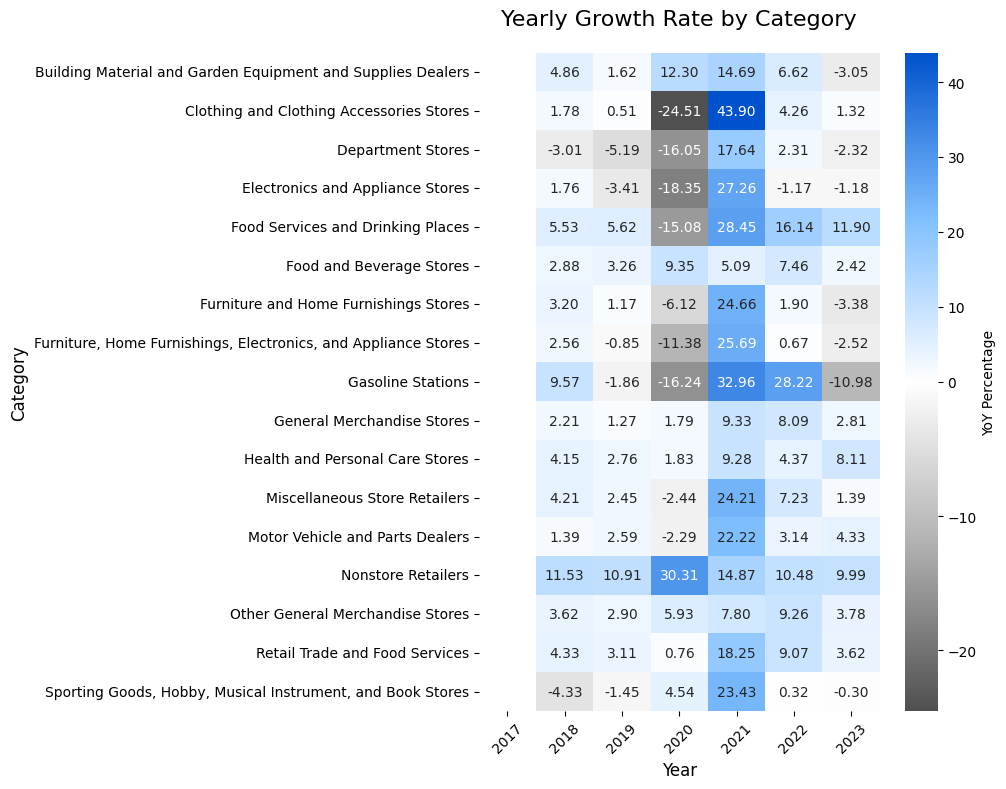

In [34]:
filtered_higher_cat_data  = yearly_sales_sum[yearly_sales_sum['is_subset'] == False]
heatmap_data = filtered_higher_cat_data.pivot(index='category_name', columns='year', values='yoy_percentage')

colors = ["#505050", "#b0b0b0", "#ffffff", "#80bfff", "#0052cc"]
custom_cmap = LinearSegmentedColormap.from_list("custom_diverging", colors)
heat_min = heatmap_data.min().min()
heat_max = heatmap_data.max().max() 

norm = TwoSlopeNorm(vmin=heat_min, vcenter=0, vmax=heat_max)

plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data, 
    cmap=custom_cmap, 
    norm=norm, 
    annot=True, 
    fmt=".2f", 
    cbar_kws={"label": "YoY Percentage"}
)
plt.title("Yearly Growth Rate by Category", fontsize=16, pad=20)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [35]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")

In [36]:
pivoted_retail = df_not_adjusted.pivot(index='time', columns='category_name', values='monthly_sales')['Retail Trade']
pivoted_food = df_not_adjusted.pivot(index='time', columns='category_name', values='monthly_sales')['Food Services and Drinking Places']
pivoted_nonstore = df_not_adjusted.pivot(index='time', columns='category_name', values='monthly_sales')['Nonstore Retailers']
pivoted_gasoline = df_not_adjusted.pivot(index='time', columns='category_name', values='monthly_sales')['Gasoline Stations']
pivoted_clothing_and_acc = df_not_adjusted.pivot(index='time', columns='category_name', values='monthly_sales')['Clothing and Clothing Accessories Stores']
pivoted_retail

time
2017-01-01   369068.00
2017-02-01   365596.00
2017-03-01   423024.00
2017-04-01   407275.00
2017-05-01   434531.00
                ...   
2023-08-01   624457.00
2023-09-01   589258.00
2023-10-01   604435.00
2023-11-01   619189.00
2023-12-01   668957.00
Name: Retail Trade, Length: 84, dtype: float64

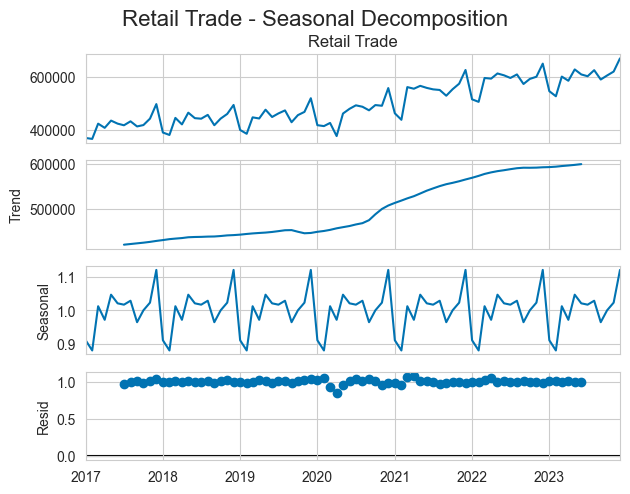

In [37]:
retail_result = seasonal_decompose(pivoted_retail, model='multiplicative', period=12)
retail_result.plot()
plt.suptitle('Retail Trade - Seasonal Decomposition', fontsize=16, y=1.02)
plt.show()

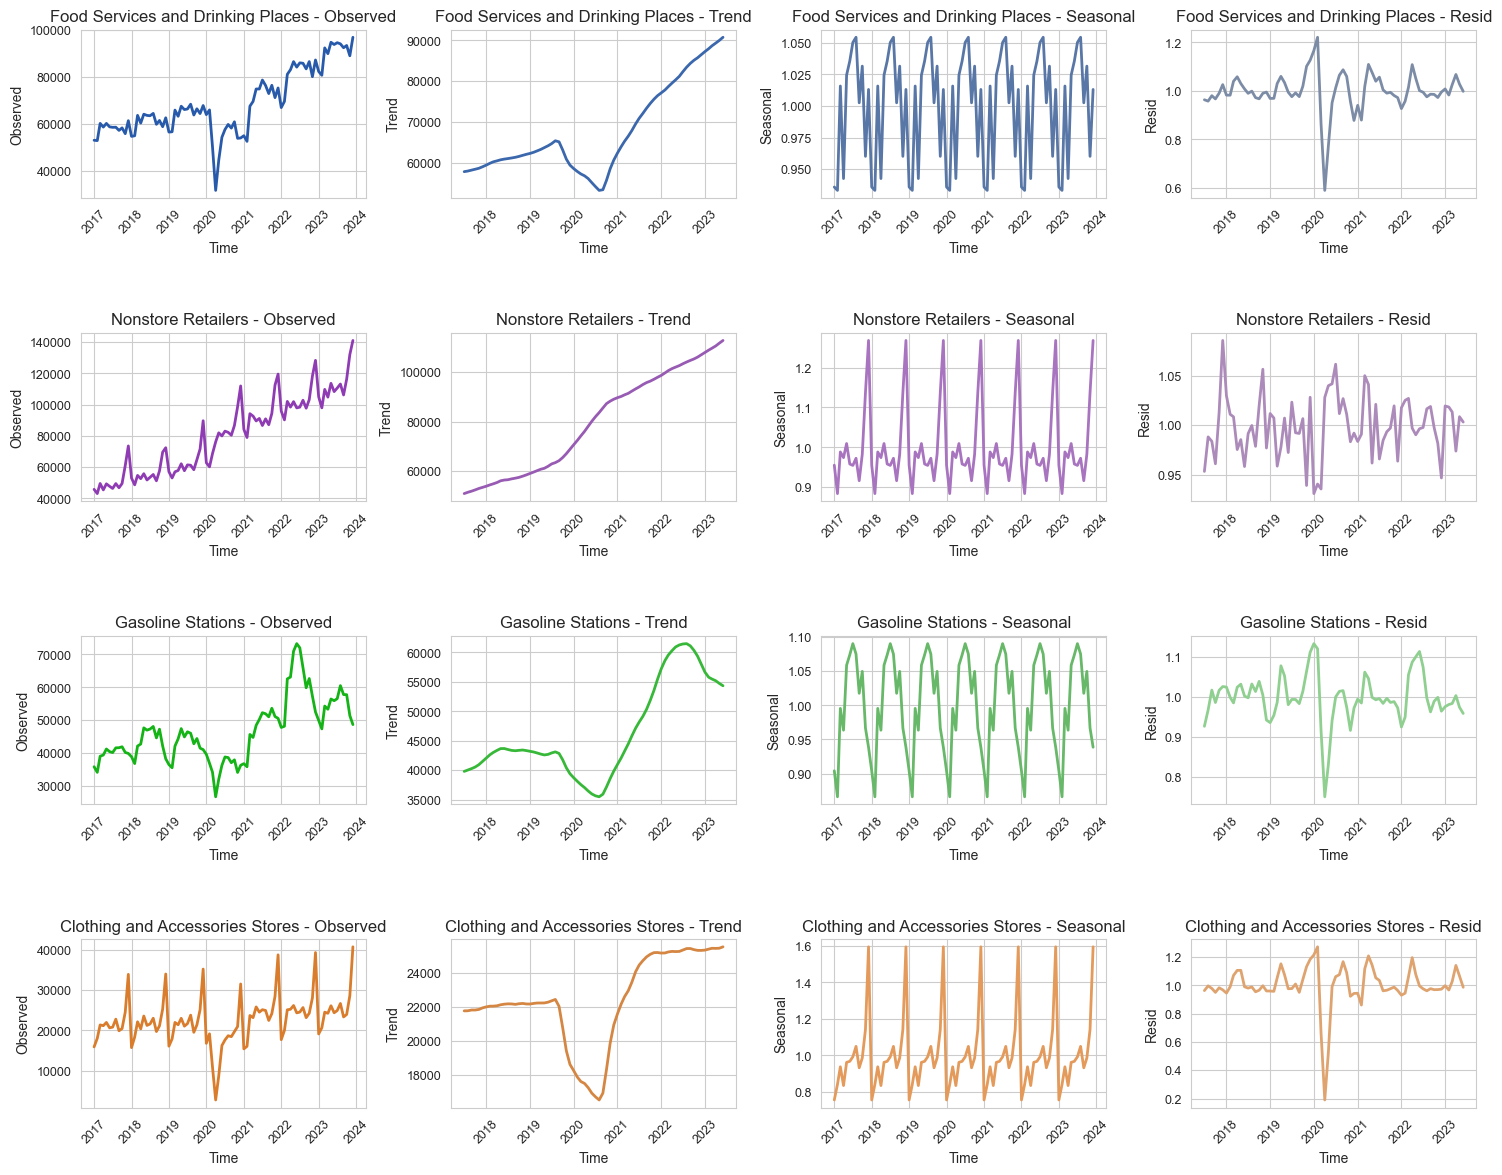

In [38]:
result_food = seasonal_decompose(pivoted_food, model='multiplicative', period=12)
result_nonstore = seasonal_decompose(pivoted_nonstore, model='multiplicative', period=12)
result_gasoline = seasonal_decompose(pivoted_gasoline, model='multiplicative', period=12)
result_clothing = seasonal_decompose(pivoted_clothing_and_acc, model='multiplicative', period=12)

fig, axes = plt.subplots(4, 4, figsize=(18, 14), gridspec_kw={'hspace': 0.8, 'wspace': 0.3})

def plot_components(result, axes, row, category_name):
    components = ['observed', 'trend', 'seasonal', 'resid']
    colors = [["#275aab","#3b67ad","#5876a6","#7c8ca6"],["#8f3bb3","#985bb3","#a873bf","#ac8aba"],["#14b316","#37b839","#67b868","#8fcf90"],["#d97c2b","#d48642","#e39a5b","#dea36f"]]
    for col, component in enumerate(components):
        axes[row, col].plot(getattr(result, component), color=colors[row][col], linewidth=2)
        axes[row, col].set_title(f'{category_name} - {component.capitalize()}', fontsize=12)
        axes[row, col].set_xlabel('Time', fontsize=10)
        axes[row, col].set_ylabel(component.capitalize(), fontsize=10)
        axes[row, col].tick_params(axis='x', rotation=45, labelsize=9)
        axes[row, col].tick_params(axis='y', labelsize=9)

plot_components(result_food, axes, 0, 'Food Services and Drinking Places')
plot_components(result_nonstore, axes, 1, 'Nonstore Retailers')
plot_components(result_gasoline, axes, 2, 'Gasoline Stations')
plot_components(result_clothing, axes, 3, 'Clothing and Accessories Stores')

plt.show()

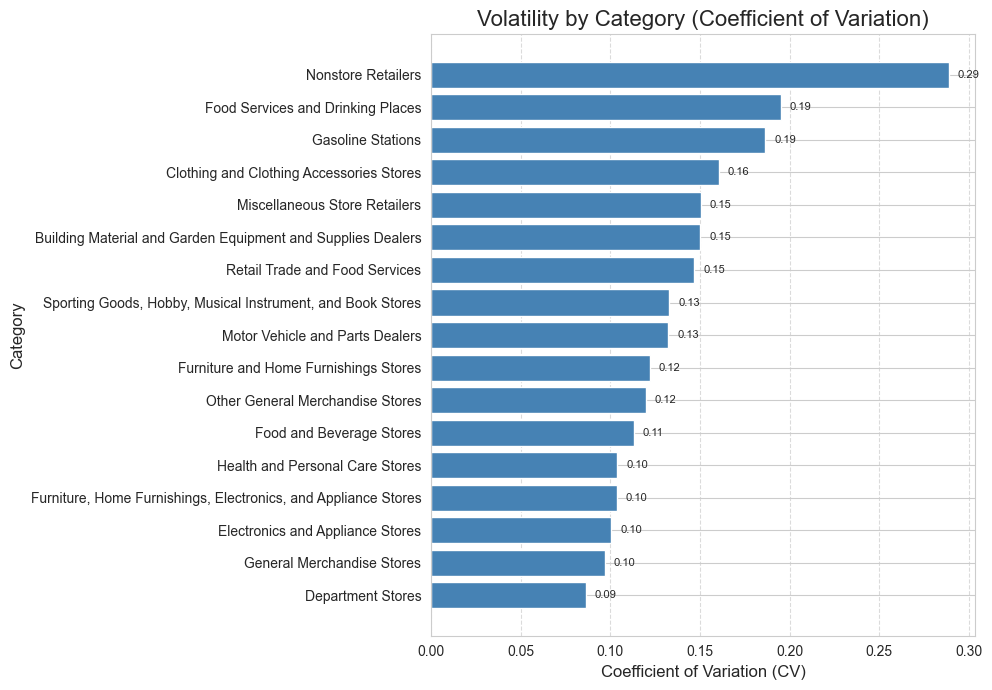

In [39]:
category_stats.sort_values(by="cv", ascending=False, inplace=True)
category_stats = category_stats[category_stats['is_subset'] == False]

plt.figure(figsize=(10, 7))
bars = plt.barh(
    category_stats["category_name"],
    category_stats["cv"],
    color="steelblue",
    edgecolor="white"
)

for bar in bars:
    plt.text(
        bar.get_width() + 0.005, 
        bar.get_y() + bar.get_height() / 2,  # center of bar
        f"{bar.get_width():.2f}",
        va="center", fontsize=8
    )

plt.xlabel("Coefficient of Variation (CV)", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.title("Volatility by Category (Coefficient of Variation)", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()


In [40]:
df_adjusted["year"] = df_adjusted["time"].dt.year

df_adjusted["yoy_growth"] = (
    df_adjusted.groupby("category_name")["monthly_sales"]
    .pct_change(periods=12, fill_method=None) * 100 
)

yoy_cv_stats = df_adjusted.groupby("category_name").agg(
    avg_yoy_growth=("yoy_growth", "mean"),  # Average YoY growth
    cv=("cv", "mean")  # CV (already exists in the dataset)
).reset_index()

yoy_cv_stats = yoy_cv_stats.dropna(subset=["avg_yoy_growth", "cv"])

# Correlation
corr, p_value = pearsonr(yoy_cv_stats["avg_yoy_growth"], yoy_cv_stats["cv"])
print(f"Correlation between CV and YoY Growth: {corr:.2f}, P-value: {p_value:.4f}")


Correlation between CV and YoY Growth: 0.67, P-value: 0.0000


In [41]:
# Calculate Z-scores for CV and YoY growth
yoy_cv_stats["cv_zscore"] = zscore(yoy_cv_stats["cv"])
yoy_cv_stats["yoy_growth_zscore"] = zscore(yoy_cv_stats["avg_yoy_growth"])

z_threshold = 2.0

# Identify outliers
outliers = yoy_cv_stats[
    (yoy_cv_stats["cv_zscore"].abs() > z_threshold) |
    (yoy_cv_stats["yoy_growth_zscore"].abs() > z_threshold)
]

print("Outliers:")
outliers[["category_name", "cv", "avg_yoy_growth", "cv_zscore", "yoy_growth_zscore"]]

Outliers:


,category_name,cv,avg_yoy_growth,cv_zscore,yoy_growth_zscore
6,Clothing Stores,0.16,16.01,0.32,2.54
7,Clothing and Clothing Accessories Stores,0.16,14.81,0.29,2.21
8,Department Stores,0.09,-0.63,-1.29,-2.03
9,Electronic Shopping and Mail-order Houses,0.31,16.10,3.45,2.57
22,Men's Clothing Stores,0.25,6.08,2.13,-0.18
25,Nonstore Retailers,0.29,14.85,3.03,2.22


Calculate CPI index (inflation) adjusted data for all MRTS data categories.

In [50]:
cpi_all_items = cpi_df[cpi_df["Expenditure category"] == "All items"].iloc[:, 2:]
cpi_all_items = cpi_all_items.T.reset_index()
cpi_all_items.columns = ["time", "cpi_index"]
cpi_all_items["time"] = pd.to_datetime(cpi_all_items["time"], format="%Y-%m")  # Convert time to datetime

df_cpi_merged = df_adjusted.merge(cpi_all_items, on="time", how="left")
df_cpi_merged["inflation_adjusted_sales"] = df_cpi_merged["monthly_sales"] / df_cpi_merged["cpi_index"] * 100

df_cpi_merged

,monthly_sales,category_code,time,category_name,high_level_category,is_subset,cv,year,yoy_growth,cpi_index,inflation_adjusted_sales
0,91596.00,441X,2017-01-01,Auto and Other Motor Vehicles,Motor Vehicle and Parts Dealers,True,0.13,2017,NaN,242.84,37718.82
1,59565.00,445,2017-01-01,Food and Beverage Stores,Food and Beverage Stores,False,0.11,2017,NaN,242.84,24528.60
2,473019.00,44X72,2017-01-01,Retail Trade and Food Services,Retail Trade and Food Services,False,0.15,2017,NaN,242.84,194787.08
3,57644.00,452,2017-01-01,General Merchandise Stores,General Merchandise Stores,False,0.10,2017,NaN,242.84,23737.54
4,7216.00,451,2017-01-01,"Sporting Goods, Hobby, Musical Instrument, and...","Sporting Goods, Hobby, Musical Instrument, and...",False,0.13,2017,NaN,242.84,2971.52
...,...,...,...,...,...,...,...,...,...,...,...
3187,8364.00,451,2023-12-01,"Sporting Goods, Hobby, Musical Instrument, and...","Sporting Goods, Hobby, Musical Instrument, and...",False,0.13,2023,-3.85,306.75,2726.69
3188,54725.00,45291,2023-12-01,Warehouse Clubs and Superstores,Other General Merchandise Stores,True,0.12,2023,2.90,306.75,17840.49
3189,18561.00,4423X,2023-12-01,"Furniture, Home Furnishings, Electronics, and ...","Furniture, Home Furnishings, Electronics, and ...",False,0.10,2023,-0.16,306.75,6050.93
3190,3153.00,44812,2023-12-01,Women's Clothing Stores,Clothing and Clothing Accessories Stores,True,0.15,2023,0.80,306.75,1027.89


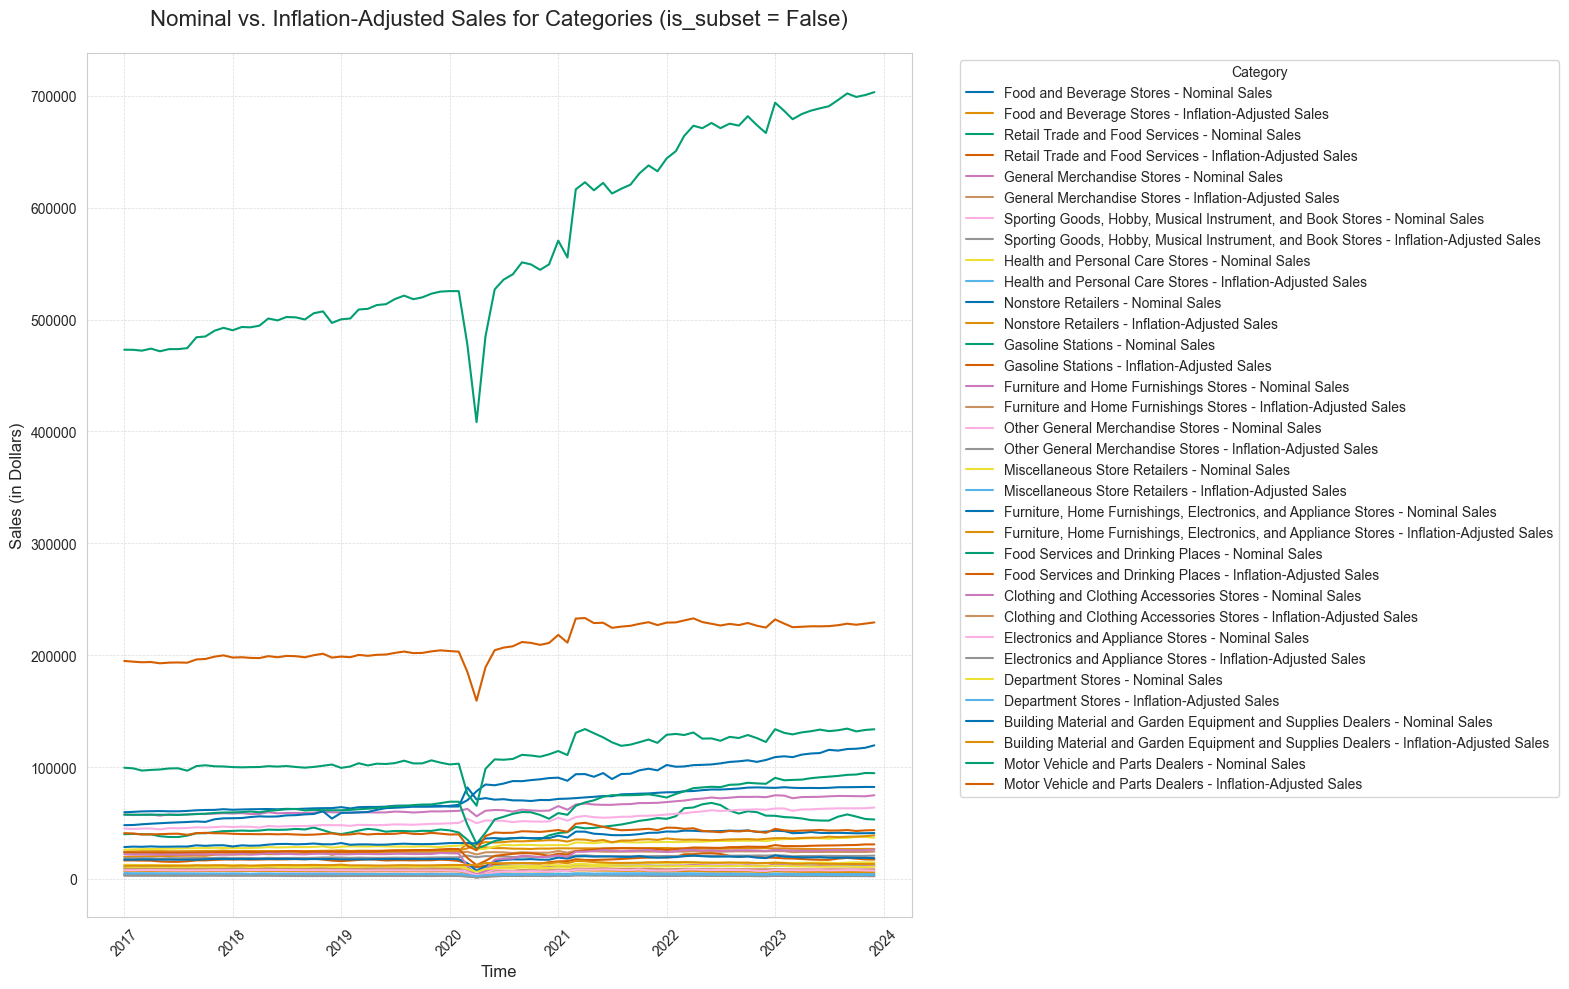

In [53]:
filtered_data = df_cpi_merged[df_cpi_merged["is_subset"] == False]

plt.figure(figsize=(16, 10))

for category in filtered_data["category_name"].unique():
    category_data = filtered_data[filtered_data["category_name"] == category]
    sns.lineplot(data=category_data, x="time", y="monthly_sales", label=f"{category} - Nominal Sales")
    sns.lineplot(data=category_data, x="time", y="inflation_adjusted_sales", label=f"{category} - Inflation-Adjusted Sales")

# Customize the plot
plt.title("Nominal vs. Inflation-Adjusted Sales for Categories (is_subset = False)", fontsize=16, pad=20)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Sales (in Dollars)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(visible=True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()
